In [26]:
import os
import sys
import torch
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import glob
import tqdm
from torchvision import transforms
from zmq import device
from torch.utils.data import Dataset
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
fontsize_pt = 10
text_width_pt = 505.89
inches_per_pt = 1.0 / 72.27
fig_width = text_width_pt * inches_per_pt
fig_height = fig_width * 0.65

params = {
    'figure.figsize': (fig_width, fig_height),
    'font.size': fontsize_pt,
    'axes.labelsize': fontsize_pt,
    'legend.fontsize': fontsize_pt * 0.9,
    'xtick.labelsize': fontsize_pt * 0.8,
    'ytick.labelsize': fontsize_pt * 0.8,
    'text.usetex': True,
    'font.family': 'serif',
}
plt.rcParams.update(params)

In [2]:
if 0:
# This script creates symbolic links in a destination directory for images from multiple source directories.
    import os

    dest_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_classification"

    src_dirs = [
        "/home/patel_zeel/kiln_compass_24/data/uttar_pradesh/images",
        "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/pakistan/pak_punjab/images",
        "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/bangladesh/dhaka/images"
    ]

    for src in src_dirs:
        folder_name = os.path.basename(os.path.dirname(src))  # e.g., uttar_pradesh, pak_punjab, dhaka
        dest_subdir = os.path.join(dest_dir, folder_name)
        os.makedirs(dest_subdir, exist_ok=True)

        for file_name in os.listdir(src):
            src_file = os.path.join(src, file_name)
            dest_link = os.path.join(dest_subdir, file_name)

            if not os.path.exists(dest_link):
                os.symlink(src_file, dest_link)

            # Crosscheck: verify link points to correct source
            if os.path.islink(dest_link):
                target = os.readlink(dest_link)
                if os.path.abspath(target) != os.path.abspath(src_file):
                    print(f"Mismatch link: {dest_link} -> {target}")
            else:
                print(f"Missing symlink: {dest_link}")


In [3]:

if 0:
# This script splits images from multiple directories into train, val, and test sets.
    import random
    import shutil

    source_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_classification"
    splits = ['train', 'val', 'test']
    split_ratio = [0.60, 0.20, 0.20]  

    for state in os.listdir(source_dir):
        state_path = os.path.join(source_dir, state)
        if not os.path.isdir(state_path):
            continue

        images = [f for f in os.listdir(state_path) if os.path.isfile(os.path.join(state_path, f))]
        random.shuffle(images)
        n = len(images)
        train_end = int(n * split_ratio[0])
        val_end = train_end + int(n * split_ratio[1])

        split_data = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split in splits:
            split_dir = os.path.join(state_path, split)
            os.makedirs(split_dir, exist_ok=True)
            for fname in split_data[split]:
                src_file = os.path.join(state_path, fname)
                dst_file = os.path.join(split_dir, fname)
                if not os.path.exists(dst_file):
                    os.symlink(src_file, dst_file)


In [4]:
if 0:
    print("Splitting completed. Check the directories for train, val, and test splits.")

In [5]:
if 0:
# This script creates a PyTorch dataset for image rotation tasks.
    from torchvision import transforms
    from torch.utils.data import Dataset
    import random
    from PIL import Image
    import os

    class RotationDataset(Dataset):
        def __init__(self, image_paths, transform=None):
            self.image_paths = image_paths
            self.transform = transform
            self.rotations = [0, 90, 180, 270]

        def __len__(self):
            return len(self.image_paths) * 4

        def __getitem__(self, idx):
            img_idx = idx // 4
            rot_idx = idx % 4
            angle = self.rotations[rot_idx]

            image = Image.open(self.image_paths[img_idx]).convert('RGB')
            image = image.rotate(angle)

            if self.transform:
                image = self.transform(image)

            return image, rot_idx


In [6]:
if 1:
# This script defines a PyTorch model for image rotation classification.
    from torchvision import models
    import torch.nn as nn

    class RotationNet(nn.Module):
        def __init__(self, base_model):
            super().__init__()
            self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # remove FC
            self.fc = nn.Linear(base_model.fc.in_features, 4)  # 4 rotation classes

        def forward(self, x):
            features = self.backbone(x)
            features = features.view(features.size(0), -1)
            out = self.fc(features)
            return out, features  # return both logits and embedding


In [7]:
if 0:
# This script prepares the dataset and dataloader for training a rotation classification model.
    images_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_classification"
    import glob
    image_paths = glob.glob(os.path.join(images_dir,'uttar_pradesh','*.tif'))  # Adjust the pattern as needed
    print(f"Found {len(image_paths)} images.")

    dataset= RotationDataset(image_paths,
                            transform=transforms.Compose([
                                transforms.Resize((640, 640)),
                                transforms.ToTensor(),
                            
                            ]))





In [8]:
if 0:
# This script trains a rotation classification model using the defined dataset and model.    
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)

    base_model = models.resnet50(pretrained=True)
    model = RotationNet(base_model).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10

    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            print(f"Epoch [{epoch+1}/{num_epochs}], Iteration [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}] Completed, Avg Loss: {epoch_loss:.4f}")
        torch.save(model.state_dict(), f"rotation_model_epoch_{epoch+1}.pth")


In [9]:
if 0:
# This script traces a PyTorch model for deployment using TorchScript.
    import timm
    import torch
    model = timm.create_model('vit_base_patch16_224', img_size=640, pretrained=True)
    dummy_input = torch.randn(1, 3, 640, 640)
    traced_model = torch.jit.trace(model, dummy_input)


In [10]:
class RotationNet(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.backbone = torch.nn.Sequential(*list(base_model.children())[:-1])
        self.fc = torch.nn.Linear(base_model.fc.in_features, 4)

    def forward(self, x):
        feat = self.backbone(x)
        feat = feat.view(feat.size(0), -1)
        out = self.fc(feat)
        return out, feat

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = self.transform(img)
        return img

def extract_embeddings(model, image_paths, transform, batch_size=32):
    dataset = ImageDataset(image_paths, transform)
    print(f"Extracting embeddings for {len(dataset)} images")
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
    embeddings = []
    with torch.no_grad():
        for batch in tqdm.tqdm(loader):
            batch = batch.to(device)
            _, feats = model(batch)
            embeddings.append(feats.cpu().numpy())
    return np.concatenate(embeddings, axis=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_paths = {
    "dhaka_r18": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints/dhaka_resnet18_epoch_20.pth",
    "pak_r18": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints/pak_punjab_resnet18_epoch_20.pth",
    "up_r18": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints/uttar_pradesh_resnet18_epoch_20.pth",
    "dhaka_r50": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints/dhaka_resnet50_epoch_20.pth",
    "pak_r50": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints/pak_punjab_resnet50_epoch_20.pth",
    "up_r50": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints/uttar_pradesh_resnet50_epoch_20.pth"
}

transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_dirs = {
    "dhaka": glob.glob("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_classification/dhaka/*.tif"),
    "pak": glob.glob("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_classification/pak_punjab/*.tif"),
    "up": glob.glob("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_classification/uttar_pradesh/*.tif")
}

# Initialize models
models_dict = {
    "dhaka_r18": RotationNet(models.resnet18(pretrained=True)),
    "pak_r18": RotationNet(models.resnet18(pretrained=True)),
    "up_r18": RotationNet(models.resnet18(pretrained=True)),
    "dhaka_r50": RotationNet(models.resnet50(pretrained=True)),
    "pak_r50": RotationNet(models.resnet50(pretrained=True)),
    "up_r50": RotationNet(models.resnet50(pretrained=True))
}

# Load checkpoints
for key in models_dict:
    state = torch.load(model_paths[key], map_location="cpu")
    models_dict[key].load_state_dict(state, strict=False)
    models_dict[key] = models_dict[key].to(device).eval()

# Extract embeddings
embeddings = {}
for model_key, model in models_dict.items():
    region = model_key.split("_")[0]
    img_paths = image_dirs[region]
    print(f"Extracting for {model_key} from {len(img_paths)} images")
    embeddings[model_key] = extract_embeddings(model, img_paths, transform)


/opt/anaconda3/envs/rishabh_sat/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/rishabh_sat/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/envs/rishabh_sat/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `we

Extracting for dhaka_r18 from 2936 images
Extracting embeddings for 2936 images


100%|██████████| 92/92 [00:07<00:00, 11.75it/s]


Extracting for pak_r18 from 36173 images
Extracting embeddings for 36173 images


100%|██████████| 1131/1131 [01:15<00:00, 15.02it/s]


Extracting for up_r18 from 38823 images
Extracting embeddings for 38823 images


100%|██████████| 1214/1214 [01:21<00:00, 14.81it/s]


Extracting for dhaka_r50 from 2936 images
Extracting embeddings for 2936 images


100%|██████████| 92/92 [00:09<00:00,  9.93it/s]


Extracting for pak_r50 from 36173 images
Extracting embeddings for 36173 images


100%|██████████| 1131/1131 [01:31<00:00, 12.32it/s]


Extracting for up_r50 from 38823 images
Extracting embeddings for 38823 images


100%|██████████| 1214/1214 [01:37<00:00, 12.40it/s]


/tmp/ipykernel_3202371/668158590.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


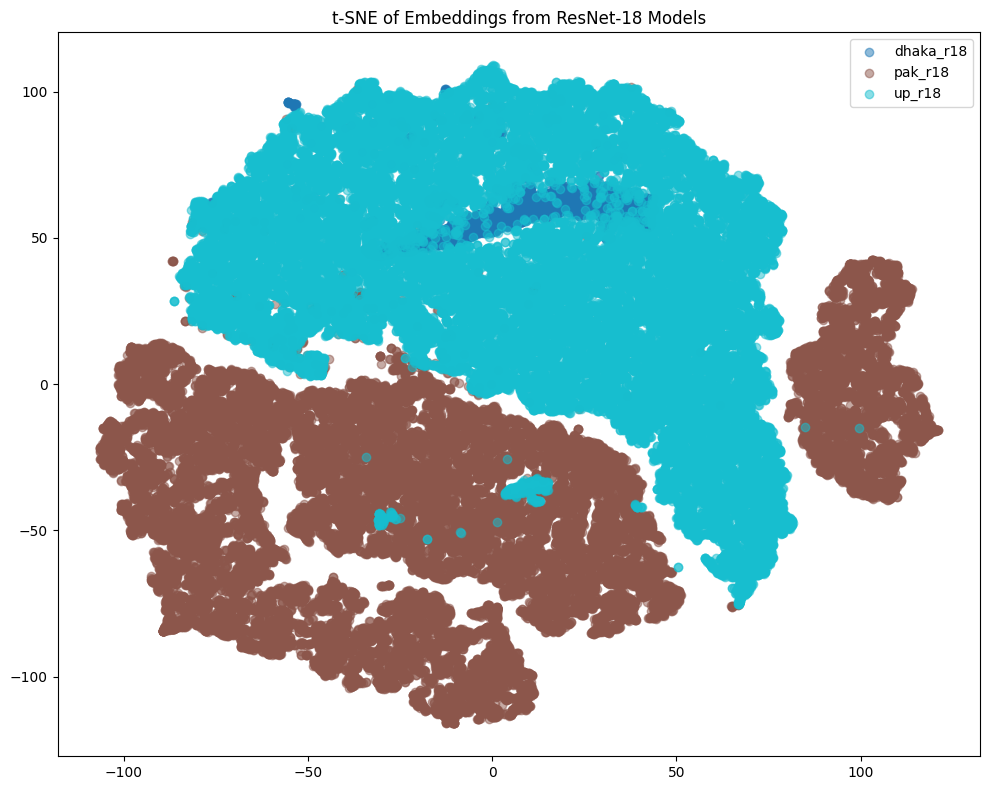

/tmp/ipykernel_3202371/668158590.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


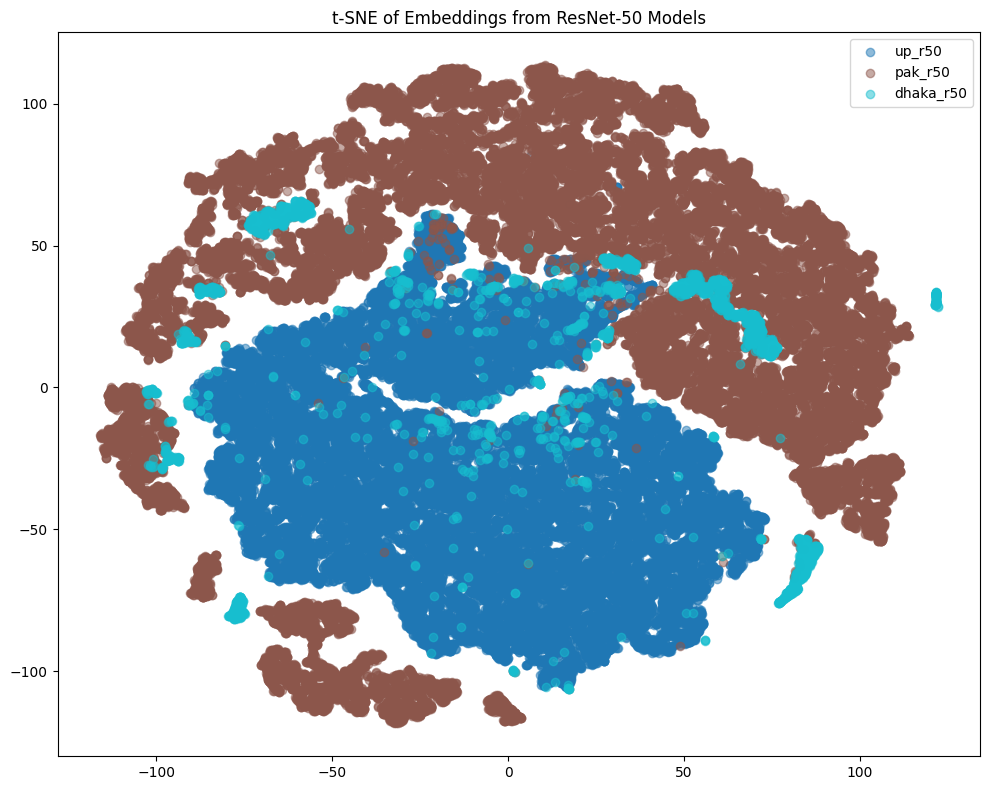

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Separate embeddings by model type
embeddings_r18 = {k: v for k, v in embeddings.items() if "r18" in k}
embeddings_r50 = {k: v for k, v in embeddings.items() if "r50" in k}

def plot_tsne(embedding_dict, title):
    reduced_embeddings = {}
    for key, embed in embedding_dict.items():
        n_components = min(50, embed.shape[0], embed.shape[1])
        pca = PCA(n_components=n_components)
        reduced_embeddings[key] = pca.fit_transform(embed)

    all_embeds = []
    all_labels = []

    for key, embed in reduced_embeddings.items():
        all_embeds.append(embed)
        all_labels.extend([key] * embed.shape[0])

    all_embeds = np.vstack(all_embeds)

    tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42)
    embeds_2d = tsne.fit_transform(all_embeds)

    plt.figure(figsize=(10, 8))
    unique_labels = list(set(all_labels))
    colors = plt.cm.get_cmap("tab10", len(unique_labels))

    for idx, label in enumerate(unique_labels):
        indices = [i for i, l in enumerate(all_labels) if l == label]
        plt.scatter(embeds_2d[indices, 0], embeds_2d[indices, 1],
                    label=label, alpha=0.5, color=colors(idx))

    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_tsne(embeddings_r18, "t-SNE of Embeddings from ResNet-18 Models")
plot_tsne(embeddings_r50, "t-SNE of Embeddings from ResNet-50 Models")


In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fontsize_pt = 10
text_width_pt = 505.89
inches_per_pt = 1.0 / 72.27
fig_width = text_width_pt * inches_per_pt
fig_height = fig_width * 0.65

plt.rcParams.update({
    'figure.figsize': (fig_width, fig_height),
    'font.size': fontsize_pt,
    'axes.labelsize': fontsize_pt,
    'legend.fontsize': fontsize_pt * 0.9,
    'xtick.labelsize': fontsize_pt * 0.8,
    'ytick.labelsize': fontsize_pt * 0.8,
    'text.usetex': True,
    'font.family': 'serif',
})

output_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/figures"
sns.set(style="white", context="paper", font_scale=1.0)

def process_embeddings(embedding_dict):
    reduced = {}
    for key, embed in embedding_dict.items():
        n_components = min(50, embed.shape[0], embed.shape[1])
        pca = PCA(n_components=n_components, random_state=42)
        reduced[key] = pca.fit_transform(embed)
    return reduced

def plot_tsne(embedding_dict, title, output_file):
    reduced = process_embeddings(embedding_dict)
    all_embeds = []
    all_labels = []

    for key, embed in reduced.items():
        all_embeds.append(embed)
        label = key.replace("_", " ").replace("r18", "").replace("r50", "").strip().title()
        all_labels.extend([label] * embed.shape[0])

    all_embeds = np.vstack(all_embeds)
    tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42, learning_rate='auto')
    embeds_2d = tsne.fit_transform(all_embeds)

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    palette = sns.color_palette("Dark2", len(set(all_labels)))

    for i, label in enumerate(sorted(set(all_labels))):
        indices = [j for j, l in enumerate(all_labels) if l == label]
        ax.scatter(
            embeds_2d[indices, 0], embeds_2d[indices, 1],
            s=30, alpha=0.9, color=palette[i], label=label,
            edgecolors='k', linewidths=0.4
        )

    ax.set_title(title, fontsize=fontsize_pt * 1.1, weight='semibold')
    ax.set_xlabel("t-SNE Component 1", fontsize=fontsize_pt)
    ax.set_ylabel("t-SNE Component 2", fontsize=fontsize_pt)
    ax.legend(title="Region", loc='best', frameon=True, fontsize=fontsize_pt * 0.9, title_fontsize=fontsize_pt)
    ax.grid(True, linestyle='--', linewidth=0.3, alpha=0.4)
    sns.despine()
    plt.tight_layout()
    plt.savefig(output_file, dpi=600, bbox_inches='tight')
    plt.close()

embeddings_r18 = {k: v for k, v in embeddings.items() if "r18" in k}
embeddings_r50 = {k: v for k, v in embeddings.items() if "r50" in k}

plot_tsne(embeddings_r18, "t-SNE of ResNet-18 Embeddings by Region", f"{output_path}/tsne_r18.pdf")
plot_tsne(embeddings_r50, "t-SNE of ResNet-50 Embeddings by Region", f"{output_path}/tsne_r50.pdf")


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

fontsize_pt = 10
text_width_pt = 505.89
inches_per_pt = 1.0 / 72.27
fig_width = text_width_pt * inches_per_pt
fig_height = fig_width * 0.65

params = {
    'figure.figsize': (fig_width, fig_height),
    'font.size': fontsize_pt,
    'axes.labelsize': fontsize_pt,
    'legend.fontsize': fontsize_pt * 0.9,
    'xtick.labelsize': fontsize_pt * 0.8,
    'ytick.labelsize': fontsize_pt * 0.8,
    'text.usetex': True,
    'font.family': 'serif',
}
plt.rcParams.update(params)

def normalize(emb):
    return emb / np.linalg.norm(emb, axis=1, keepdims=True)

r18_keys = ['dhaka_r18', 'pak_r18', 'up_r18']
r50_keys = ['dhaka_r50', 'pak_r50', 'up_r50']
labels = ['Dhaka', 'Pak Punjab', 'Uttar Pradesh']
region_embeddings = {k: normalize(embeddings[k]) for k in r18_keys + r50_keys}
cmap = sns.color_palette("rocket_r", as_cmap=True)

def plot_heatmap(keys, title, filename):
    n = len(keys)
    matrix = np.zeros((n, n))
    annotations = np.empty((n, n), dtype=object)
    for i, ki in enumerate(keys):
        for j, kj in enumerate(keys):
            sim = cosine_similarity(region_embeddings[ki], region_embeddings[kj])
            mean = sim.mean()
            std = sim.std()
            matrix[i, j] = mean
            annotations[i, j] = f"{mean:.2f}±{std:.2f}"

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    sns.heatmap(matrix, annot=annotations, fmt="", cmap=cmap,
                xticklabels=labels, yticklabels=labels,
                cbar_kws={"label": "Cosine Similarity"}, square=True,
                linewidths=0.6, linecolor='lightgray',
                annot_kws={"fontsize": fontsize_pt * 0.9}, ax=ax)
    ax.set_title(title, fontsize=fontsize_pt * 1.2, weight='semibold')
    ax.tick_params(axis='x', rotation=30)
    ax.tick_params(axis='y', rotation=0)
    plt.tight_layout()
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.close()

plot_heatmap(r18_keys, "ResNet-18", "cosine_similarity_r18.pdf")
plot_heatmap(r50_keys, "ResNet-50", "cosine_similarity_r50.pdf")


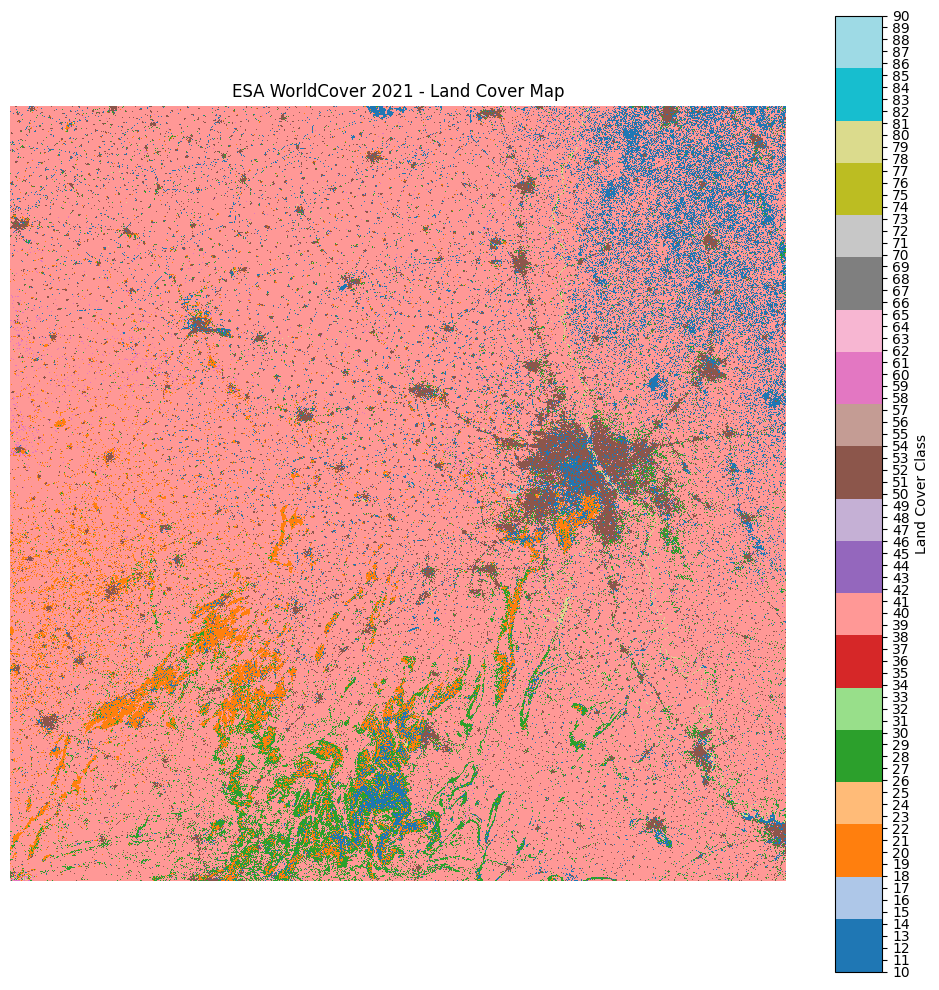

In [9]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps
from matplotlib.colors import ListedColormap

# Load the raster
tif_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/ESA_WorldCover_10m_2021_v200_N27E075_Map.tif"

with rasterio.open(tif_path) as src:
    image = src.read(1)
    n_classes = int(np.max(image)) + 1
    base_cmap = colormaps.get_cmap('tab20')
    cmap = ListedColormap(base_cmap(np.linspace(0, 1, n_classes)))

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap=cmap, interpolation='none')
plt.colorbar(ticks=range(n_classes), label='Land Cover Class')
plt.title("ESA WorldCover 2021 - Land Cover Map")
plt.axis('off')
plt.tight_layout()
plt.show()
